In [1]:
# Mofication History
# v0.1 Initial
# v0.2 update LAST, last SECOND and last THIRD layer
# v0.3 greedy update by the last best result and full training dataset
# v0.4 using scheduler: ReduceLROnPlateau

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

import imgaug as ia
from imgaug import augmenters as iaa
import copy

%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from os import listdir
from os.path import join, basename, isdir, isfile
import shutil

from PIL import Image
import time


In [3]:
# Parameter Claim
BATCH_SIZE = 32        # Batch Size
LR         = 0.1       # Initial Learning Rate
EPOCH      = 200        # Training Epoches
IMAGE_SIZE = 224        # Image dimension
MOMENTUM   = 0.9        # Momentum
device     = 'cuda'

In [4]:
def train_model(data_loader, model, criterion, optimizer, epoch, is_train=True):
    # switch to train or test mode
    model.train(is_train)
    
    running_loss = 0.0
    running_corrects = 0
    data_len = 0
    
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # backward + optimize only if in training phase
        if is_train:
            loss.backward()
            optimizer.step()
            
        # statistics
        running_loss += loss.item()
        running_corrects += preds.eq(labels).sum().item()    
        data_len += len(labels)
        
    # Record statistics
    epoch_acc = 100.*running_corrects / data_len
    epoch_loss = running_loss / data_len
    
    if is_train:
        print('{:3d} epoch, training '.format(epoch+1), end='')
    else:
        print('            testing ', end='')
    print('accuracy: {:.1f}%'.format(epoch_acc))
    print('                    loss    : {:.3f}'.format(epoch_loss))
    return epoch_acc, epoch_loss

In [5]:
def transformation(size=224, aug=False):
    if aug:
        return transforms.Compose([
            transforms.RandomResizedCrop(size),
            #transforms.RandomAffine(45),
            transforms.RandomRotation(90),
            #transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.555, 0.451, 0.344), (0.228, 0.238, 0.238)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize((0.555, 0.451, 0.344), (0.228, 0.238, 0.238)),
        ])       
        

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


class DatasetFromFolder(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.transform = transform

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        input = Image.open(filename)
        #label = basename(filename).split('_', 1)[0]
        if self.transform:
            input = self.transform(input)
        label = basename(filename).split('_')[0:2]
        if label[0].isdigit():
            label = label[0]
        else:
            label = label[1]
        #print("filename, label", filename, label)
        return input, int(label)

    def __len__(self):
        return len(self.image_filenames)
    
    
def get_data_set(datadir, subdir='Food-11/training', aug=False):
    train_dir = join(datadir, subdir)
    return DatasetFromFolder(train_dir, transform=transformation(IMAGE_SIZE, aug))


def adjust_learning_rate(optimizer, epoch):
    lr = LR * (0.5 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    if epoch%20 == 0:
        print('Learning rate is {:.5f}'.format(lr))

In [6]:
# Main function
if __name__ == '__main__':
    classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice',
               'Seafood', 'Soup', 'Vegetable/Fruit')
    
    mode = ['LAST', 'SECOND', 'THIRD']
    
    # Data loading
    datadir = '../data'
    if not isdir(datadir):
        datadir = '/tmp/dataset-nctu'
    
    #trainset = get_data_set('/tmp/work', 'LAB3-2/sampled_train', True)
    trainset = get_data_set(datadir, 'Food-11/training', True)
    validset = get_data_set(datadir, 'Food-11/validation')
    TRAIN_SIZE, VALID_SIZE = len(trainset), len(validset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
      

    best_accu = [0, 0, 0]
    train_accu, train_loss = [[],[],[]], [[],[],[]]
    val_accu, val_loss = [[],[],[]], [[],[],[]]
    
    for idx in range(3): #0:model_last, 1:model_second, 2:model_third
        print('Transfer learning mode {} is begining...'.format(mode[idx]))
        criterion = nn.CrossEntropyLoss()
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, len(classes))
        for param in model.parameters():
            param.requires_grad = False # do not update gradient
        for param in model.fc.parameters():
            param.requires_grad = True # update gradient
                
        
        if idx==0: # Transfer learning and update FC's weight
            optimizer = optim.RMSprop(model.fc.parameters(), lr=LR, alpha=0.9)
            
        elif idx==1: # Transfer learning and update FC and layer4's weights
            for param in model.layer4.parameters():
                param.requires_grad = True # do not update gradient
            optimizer = optim.RMSprop([{'params': model.fc.parameters()}, 
                                       {'params': model.layer4.parameters()}
                                      ], lr=LR, alpha=0.9)
            
        else: # Transfer learning and update FC and layer4's and layer3's weights
            for param in model.layer4.parameters():
                param.requires_grad = True # do not update gradient
            for param in model.layer3.parameters():
                param.requires_grad = True # do not update gradient
            optimizer = optim.RMSprop([{'params': model.fc.parameters()}, 
                                       {'params': model.layer4.parameters()},
                                       {'params': model.layer3.parameters()}
                                      ], lr=LR, alpha=0.9)
            
        #for name, param in model.named_parameters():
        #    print (name, '\t', param.requires_grad)
        
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)
        
        model = model.to(device)

        # Do Training
        for epoch in range(EPOCH):
            # Adjust learning rate
            #scheduler.step()

            # train for one epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            accu_t, loss_t = train_model(trainloader, model, criterion, optimizer, epoch)
            train_accu[idx].append(accu_t)
            train_loss[idx].append(loss_t)
            accu_v, loss_v = train_model(validloader, model, criterion, optimizer, epoch, False)
            val_accu[idx].append(accu_v)
            val_loss[idx].append(loss_v)
            scheduler.step(loss_v)
            if accu_v > best_accu[idx]:
                best_accu[idx] = accu_v
                fname = './ckpt/model_best_bonus_v04_'+mode[idx]+'.pth.tar'
                torch.save(model.state_dict(), fname)
            else:
                model.load_state_dict(best_model_wts)

        print('Transfer learning mode {} is DONE.\n\n\n'.format(mode[idx]))
        del criterion
        del scheduler 
        del model
        del optimizer
    
    print('\n\nTransfer learning is DONE.')


Transfer learning mode LAST is begining...
  1 epoch, training accuracy: 40.3%
                    loss    : 1.748
            testing accuracy: 47.9%
                    loss    : 1.229
  2 epoch, training accuracy: 53.1%
                    loss    : 1.196
            testing accuracy: 28.4%
                    loss    : 3.515
  3 epoch, training accuracy: 53.4%
                    loss    : 1.174
            testing accuracy: 57.6%
                    loss    : 1.219
  4 epoch, training accuracy: 56.2%
                    loss    : 1.167
            testing accuracy: 56.9%
                    loss    : 1.155
  5 epoch, training accuracy: 57.1%
                    loss    : 1.112
            testing accuracy: 59.9%
                    loss    : 1.171
  6 epoch, training accuracy: 58.8%
                    loss    : 1.120
            testing accuracy: 63.0%
                    loss    : 1.031
  7 epoch, training accuracy: 59.2%
                    loss    : 1.116
            testing a

            testing accuracy: 69.4%
                    loss    : 0.518
 58 epoch, training accuracy: 70.2%
                    loss    : 0.444
            testing accuracy: 77.1%
                    loss    : 0.332
 59 epoch, training accuracy: 69.5%
                    loss    : 0.451
            testing accuracy: 75.9%
                    loss    : 0.364
 60 epoch, training accuracy: 70.0%
                    loss    : 0.431
            testing accuracy: 74.1%
                    loss    : 0.384
 61 epoch, training accuracy: 70.2%
                    loss    : 0.437
            testing accuracy: 73.0%
                    loss    : 0.427
 62 epoch, training accuracy: 70.5%
                    loss    : 0.451
            testing accuracy: 75.0%
                    loss    : 0.353
 63 epoch, training accuracy: 70.1%
                    loss    : 0.436
            testing accuracy: 71.2%
                    loss    : 0.450
 64 epoch, training accuracy: 69.9%
                    loss    

114 epoch, training accuracy: 71.8%
                    loss    : 0.300
            testing accuracy: 76.1%
                    loss    : 0.261
115 epoch, training accuracy: 72.2%
                    loss    : 0.287
            testing accuracy: 76.9%
                    loss    : 0.260
116 epoch, training accuracy: 72.2%
                    loss    : 0.292
            testing accuracy: 76.4%
                    loss    : 0.240
117 epoch, training accuracy: 71.7%
                    loss    : 0.292
            testing accuracy: 76.6%
                    loss    : 0.244
Epoch   116: reducing learning rate of group 0 to 6.2500e-03.
118 epoch, training accuracy: 73.1%
                    loss    : 0.269
            testing accuracy: 78.5%
                    loss    : 0.238
119 epoch, training accuracy: 72.6%
                    loss    : 0.276
            testing accuracy: 79.0%
                    loss    : 0.232
120 epoch, training accuracy: 73.0%
                    loss    : 0.273
  

169 epoch, training accuracy: 74.5%
                    loss    : 0.256
            testing accuracy: 79.9%
                    loss    : 0.217
170 epoch, training accuracy: 74.1%
                    loss    : 0.262
            testing accuracy: 79.1%
                    loss    : 0.234
171 epoch, training accuracy: 73.7%
                    loss    : 0.258
            testing accuracy: 79.5%
                    loss    : 0.227
172 epoch, training accuracy: 73.9%
                    loss    : 0.253
            testing accuracy: 79.5%
                    loss    : 0.231
173 epoch, training accuracy: 73.8%
                    loss    : 0.269
            testing accuracy: 79.6%
                    loss    : 0.221
174 epoch, training accuracy: 73.9%
                    loss    : 0.265
            testing accuracy: 78.5%
                    loss    : 0.236
175 epoch, training accuracy: 74.1%
                    loss    : 0.261
            testing accuracy: 79.2%
                    loss    

 24 epoch, training accuracy: 75.9%
                    loss    : 0.024
            testing accuracy: 81.2%
                    loss    : 0.019
 25 epoch, training accuracy: 76.3%
                    loss    : 0.024
            testing accuracy: 75.1%
                    loss    : 0.026
 26 epoch, training accuracy: 76.4%
                    loss    : 0.023
            testing accuracy: 82.5%
                    loss    : 0.017
 27 epoch, training accuracy: 75.7%
                    loss    : 0.023
            testing accuracy: 80.9%
                    loss    : 0.019
 28 epoch, training accuracy: 75.5%
                    loss    : 0.024
            testing accuracy: 82.1%
                    loss    : 0.018
 29 epoch, training accuracy: 76.3%
                    loss    : 0.023
            testing accuracy: 82.2%
                    loss    : 0.019
 30 epoch, training accuracy: 76.1%
                    loss    : 0.024
            testing accuracy: 78.3%
                    loss    

            testing accuracy: 83.9%
                    loss    : 0.015
 81 epoch, training accuracy: 78.8%
                    loss    : 0.021
            testing accuracy: 83.9%
                    loss    : 0.016
 82 epoch, training accuracy: 78.2%
                    loss    : 0.021
            testing accuracy: 84.0%
                    loss    : 0.016
 83 epoch, training accuracy: 78.7%
                    loss    : 0.021
            testing accuracy: 84.0%
                    loss    : 0.016
 84 epoch, training accuracy: 78.8%
                    loss    : 0.021
            testing accuracy: 82.9%
                    loss    : 0.017
 85 epoch, training accuracy: 78.5%
                    loss    : 0.021
            testing accuracy: 84.6%
                    loss    : 0.016
 86 epoch, training accuracy: 78.1%
                    loss    : 0.021
            testing accuracy: 79.6%
                    loss    : 0.021
 87 epoch, training accuracy: 78.8%
                    loss    

135 epoch, training accuracy: 80.0%
                    loss    : 0.020
            testing accuracy: 84.8%
                    loss    : 0.015
136 epoch, training accuracy: 79.9%
                    loss    : 0.019
            testing accuracy: 84.7%
                    loss    : 0.015
Epoch   135: reducing learning rate of group 0 to 1.5625e-03.
Epoch   135: reducing learning rate of group 1 to 1.5625e-03.
137 epoch, training accuracy: 79.7%
                    loss    : 0.020
            testing accuracy: 85.4%
                    loss    : 0.015
138 epoch, training accuracy: 80.4%
                    loss    : 0.019
            testing accuracy: 84.8%
                    loss    : 0.015
            testing accuracy: 84.8%
                    loss    : 0.015
140 epoch, training accuracy: 80.3%
                    loss    : 0.019
            testing accuracy: 85.0%
                    loss    : 0.015
141 epoch, training accuracy: 79.6%
                    loss    : 0.019
            

189 epoch, training accuracy: 80.1%
                    loss    : 0.020
            testing accuracy: 85.1%
                    loss    : 0.015
190 epoch, training accuracy: 81.2%
                    loss    : 0.018
            testing accuracy: 85.3%
                    loss    : 0.015
Epoch   189: reducing learning rate of group 0 to 9.7656e-05.
Epoch   189: reducing learning rate of group 1 to 9.7656e-05.
191 epoch, training accuracy: 80.3%
                    loss    : 0.019
            testing accuracy: 85.2%
                    loss    : 0.015
192 epoch, training accuracy: 80.8%
                    loss    : 0.019
            testing accuracy: 85.2%
                    loss    : 0.015
193 epoch, training accuracy: 80.2%
                    loss    : 0.019
            testing accuracy: 85.4%
                    loss    : 0.015
194 epoch, training accuracy: 80.3%
                    loss    : 0.019
            testing accuracy: 85.0%
                    loss    : 0.015
195 epoch, t

 43 epoch, training accuracy: 68.9%
                    loss    : 0.029
            testing accuracy: 72.8%
                    loss    : 0.026
 44 epoch, training accuracy: 68.6%
                    loss    : 0.030
            testing accuracy: 74.2%
                    loss    : 0.024
 45 epoch, training accuracy: 69.4%
                    loss    : 0.029
            testing accuracy: 73.3%
                    loss    : 0.025
 46 epoch, training accuracy: 69.5%
                    loss    : 0.029
            testing accuracy: 72.4%
                    loss    : 0.026
 47 epoch, training accuracy: 69.5%
                    loss    : 0.030
            testing accuracy: 74.7%
                    loss    : 0.024
 48 epoch, training accuracy: 70.1%
                    loss    : 0.029
            testing accuracy: 72.8%
                    loss    : 0.025
 49 epoch, training accuracy: 69.9%
                    loss    : 0.029
            testing accuracy: 73.4%
                    loss    

 99 epoch, training accuracy: 73.4%
                    loss    : 0.025
            testing accuracy: 78.3%
                    loss    : 0.020
100 epoch, training accuracy: 73.8%
                    loss    : 0.025
            testing accuracy: 78.7%
                    loss    : 0.021
101 epoch, training accuracy: 73.9%
                    loss    : 0.025
            testing accuracy: 77.1%
                    loss    : 0.022
102 epoch, training accuracy: 74.1%
                    loss    : 0.025
            testing accuracy: 78.9%
                    loss    : 0.020
103 epoch, training accuracy: 73.0%
                    loss    : 0.025
            testing accuracy: 77.3%
                    loss    : 0.021
104 epoch, training accuracy: 73.6%
                    loss    : 0.025
            testing accuracy: 78.9%
                    loss    : 0.020
105 epoch, training accuracy: 74.2%
                    loss    : 0.025
            testing accuracy: 78.2%
                    loss    

155 epoch, training accuracy: 75.3%
                    loss    : 0.024
            testing accuracy: 79.5%
                    loss    : 0.019
156 epoch, training accuracy: 75.5%
                    loss    : 0.024
            testing accuracy: 79.1%
                    loss    : 0.020
157 epoch, training accuracy: 74.7%
                    loss    : 0.024
            testing accuracy: 79.7%
                    loss    : 0.020
158 epoch, training accuracy: 75.7%
                    loss    : 0.023
            testing accuracy: 78.9%
                    loss    : 0.020
159 epoch, training accuracy: 74.8%
                    loss    : 0.024
            testing accuracy: 79.4%
                    loss    : 0.020
160 epoch, training accuracy: 75.0%
                    loss    : 0.024
            testing accuracy: 79.1%
                    loss    : 0.020
161 epoch, training accuracy: 75.3%
                    loss    : 0.024
            testing accuracy: 78.0%
                    loss    

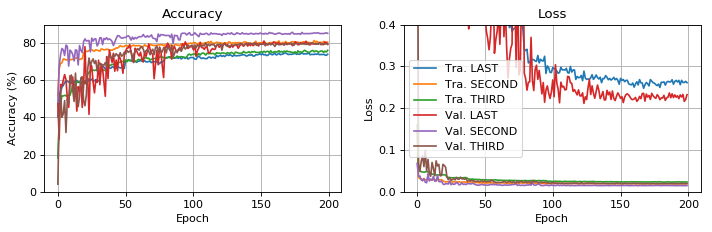

In [7]:
def draw_tri_accuracy(train_accu, train_loss, val_accu, val_loss):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3), dpi=80)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Accuracy')
    ax1.grid(b=True)
    ax1.plot(train_accu[0], label='Tra. LAST')
    ax1.plot(train_accu[1], label='Tra. SECOND')
    ax1.plot(train_accu[2], label='Tra. THIRD')
    ax1.plot(val_accu[0], label='Val. LAST')
    ax1.plot(val_accu[1], label='Val. SECOND')
    ax1.plot(val_accu[2], label='Val. THIRD')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.grid(b=True)
    ax2.set_ylim(0,0.4)
    ax2.plot(train_loss[0], label='Tra. LAST')
    ax2.plot(train_loss[1], label='Tra. SECOND')
    ax2.plot(train_loss[2], label='Tra. THIRD')
    ax2.plot(val_loss[0], label='Val. LAST')
    ax2.plot(val_loss[1], label='Val. SECOND')
    ax2.plot(val_loss[2], label='Val. THIRD')

    plt.legend()    
    plt.tight_layout()
    
draw_tri_accuracy(train_accu, train_loss, val_accu, val_loss)

In [9]:
# Evaluation
evaluateset = get_data_set(datadir, 'Food-11/evaluation')
evaluateloader = torch.utils.data.DataLoader(evaluateset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
    
for idx in range(3): #0:model_scrach, 1:model_all, 2:model_last
    print('Evaluation of mode {}.'.format(mode[idx]))
    fname = './ckpt/model_best_bonus_v04_'+mode[idx]+'.pth.tar'
    model = models.resnet50()
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    model.load_state_dict(torch.load(fname))
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    
    train_model(evaluateloader, model, criterion, optimizer, 0, False)
    
    del model
    del optimizer

Evaluation of mode LAST.
            testing accuracy: 81.7%
                    loss    : 0.185
Evaluation of mode SECOND.
            testing accuracy: 87.0%
                    loss    : 0.013
Evaluation of mode THIRD.
            testing accuracy: 82.0%
                    loss    : 0.017
